In [67]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [68]:
import pandas as pd
df_arth = pd.read_csv('df_arth.csv')
df_arth.head()

,DRDXAR2,PHYS14D,TOTINDA,SEX,AGE_G,BMI5CAT,EDUCAG,INCOMG1,RFSMOK3,DRNKANY6,SSBSUGR2_en
0,1,1,2,1,6,3,4,6,1,2,0
1,2,1,1,2,6,3,4,5,1,2,0
2,1,1,2,2,6,4,4,4,1,1,0
3,2,1,1,2,3,4,4,7,1,2,2
4,1,1,1,1,6,4,3,5,1,2,0


In [69]:
df_arth['DRDXAR2'].value_counts()

DRDXAR2
2    53542
1    29317
Name: count, dtype: int64

In [70]:
df_arth['DRDXAR2'] = df_arth['DRDXAR2'].map({1: 1, 2: 0}).astype(int)

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_arth.drop('DRDXAR2', axis=1)
y = df_arth['DRDXAR2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (66287, 10)
Shape of X_test: (16572, 10)
Shape of y_train: (66287,)
Shape of y_test: (16572,)


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

models = [
    ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)),
    ("HistGradientBoosting", HistGradientBoostingClassifier(random_state=42)),
    ("GradientBoosting", GradientBoostingClassifier(random_state=42)),
    ("XGBClassifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

for name, model in models:
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"{name} - Train Accuracy: {train_score:.4f}, Test Accuracy: {test_score:.4f}")

LogisticRegression(max_iter=1000, random_state=42)

LogisticRegression - Train Accuracy: 0.7232, Test Accuracy: 0.7207


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

RandomForest - Train Accuracy: 0.8012, Test Accuracy: 0.6974


HistGradientBoostingClassifier(random_state=42)

HistGradientBoosting - Train Accuracy: 0.7304, Test Accuracy: 0.7222


GradientBoostingClassifier(random_state=42)

GradientBoosting - Train Accuracy: 0.7256, Test Accuracy: 0.7233


c:\Users\samsu\Desktop\COLLEGE\Predictive\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:29:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

XGBClassifier - Train Accuracy: 0.7417, Test Accuracy: 0.7183


In [73]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    
}

# Parameter distributions for RandomizedSearchCV
# Note: Using distributions (like uniform, randint) is possible but for simplicity, we use lists of values.
param_grids = {
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "GradientBoosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# --- 3. Run Hyperparameter Tuning ---

# Store results
best_models = {}

for name in models:
    print(f"--- Tuning {name} ---")
    
    # Initialize RandomizedSearchCV
    # n_iter controls how many different parameter combinations are tried.
    # cv is the number of folds in cross-validation.
    random_search = RandomizedSearchCV(
        estimator=models[name],
        param_distributions=param_grids[name],
        n_iter=10,  # Increase for more thorough search
        cv=3,       # Use 3-fold cross-validation
        verbose=1,
        random_state=42,
        n_jobs=-1   # Use all available CPU cores
    )
    
    # Fit the model
    random_search.fit(X_train, y_train)
    
    # Store the best estimator
    best_models[name] = random_search.best_estimator_
    
    # Print the results
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best CV Score (Accuracy): {random_search.best_score_:.4f}")
    print("-" * (len(name) + 12) + "\n")


# --- 4. Evaluate Best Models on Test Set ---
print("\n--- Evaluating Best Models on Test Data ---\n")

for name, model in best_models.items():
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{name}:")
    print(f"  - Test Accuracy: {test_accuracy:.4f}")

--- Tuning RandomForest ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=1)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
Best CV Score (Accuracy): 0.7227
------------------------

--- Tuning GradientBoosting ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200]},
                   random_state=42, verbose=1)

Best Parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2}
Best CV Score (Accuracy): 0.7223
----------------------------


--- Evaluating Best Models on Test Data ---

RandomForest:
  - Test Accuracy: 0.7215
GradientBoosting:
  - Test Accuracy: 0.7230


In [74]:
from sklearn.metrics import classification_report, roc_auc_score
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name}:  - AUC-ROC: {auc_roc:.4f}\n")
    print(f"Classification Report:{name}")
    print(classification_report(y_test, y_pred))

RandomForest:  - AUC-ROC: 0.7827

Classification Report:RandomForest
              precision    recall  f1-score   support

           0       0.76      0.84      0.80     10768
           1       0.63      0.51      0.56      5804

    accuracy                           0.72     16572
   macro avg       0.69      0.67      0.68     16572
weighted avg       0.71      0.72      0.71     16572

GradientBoosting:  - AUC-ROC: 0.7861

Classification Report:GradientBoosting
              precision    recall  f1-score   support

           0       0.76      0.83      0.80     10768
           1       0.63      0.52      0.57      5804

    accuracy                           0.72     16572
   macro avg       0.69      0.68      0.68     16572
weighted avg       0.72      0.72      0.72     16572



In [75]:
from sklearn.ensemble import GradientBoostingClassifier

# Create the model with best parameters
model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.2,
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Evaluate performance
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"GradientBoostingClassifier - Train Accuracy: {train_score:.4f}, Test Accuracy: {test_score:.4f}")

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


GradientBoostingClassifier(learning_rate=0.2, n_estimators=200, random_state=42)

GradientBoostingClassifier - Train Accuracy: 0.7273, Test Accuracy: 0.7230


In [76]:
threshold = 0.6
y_custom_pred = (y_pred_proba >= threshold).astype(int)


In [77]:
y_custom_pred


array([1, 0, 0, ..., 0, 0, 0])

Text(0.5, 1.0, 'Confusion Matrix')

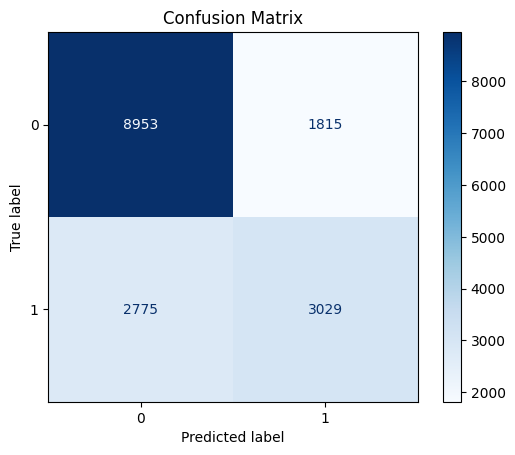

<Figure size 800x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC)')

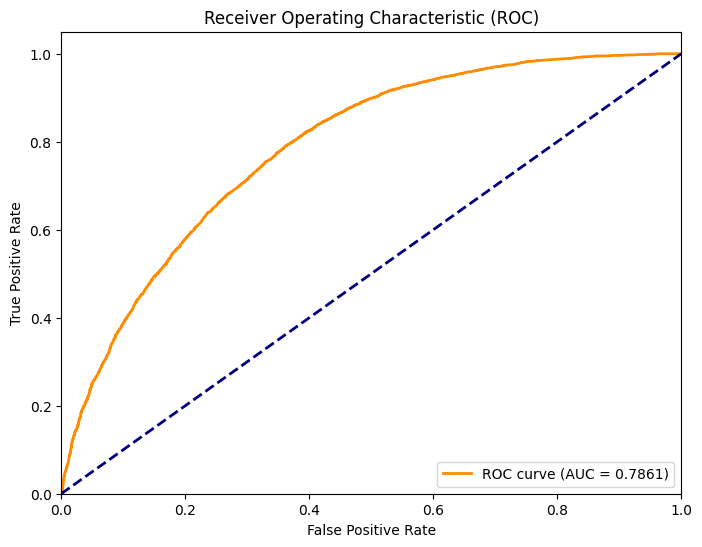

ROC-AUC Score: 0.7861


In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 3. ROC-AUC Score
roc_auc_score_value = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc_score_value:.4f}")


In [79]:
import joblib
#  Save scaler and model separately
joblib.dump(model, "grad_model_arth.pkl")
print("✅ Scaler and model saved successfully!")

['grad_model_arth.pkl']

✅ Scaler and model saved successfully!
